<img style="border:2px solid black;" src="accueil.png" width=100% border="5"> </center> 
# <span style="color:blue">Porous Media - Flow modelling tools using Jupyter </span>
## <span style="color:red"> PYGRDECL based Upscaling notebook </span>

## <span style="color:blue"> 1. Create initial GRDECL ECLIPSE/PETREL Pillar Grid </span>

In [1]:
from GRDECL2VTK import *

# 1.1 Set physical dimensions in physDims (m)
physDims=[2000.0,1000,500]

# 1.2 Set model grid dimensions in gridDims
Nx=30;  Ny=15;  Nz=Nx
gridDims=[Nx,Ny,Nz]

# 1.3 Set corner point grid options
opt=buildCPGGrid_opt(disturbed=False,     flat=True,\
                     fault_drop=400 , fault_nx=Nx//2)

# 1.4 Create empty GeologyModel - Build CPG
Model=GeologyModel()
Model.buildCPGGrid(physDims,gridDims,opt)

# 1.5 Compute First TPFA (block centered) Pressure values
Model.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
Model.plot_scalar("Pressure",ITK=True).show()

     Creating Grid:
       Type: CornerPoint Grid
       Grid Dimensions (NX,NY,NZ): (30 x 15 x 30)
       Number Of Grid Cells: 13500
       Created: Fields: ***PERMX***PERMY***PERMZ***PORO***
[CreateCellData] New variable [Pressure] created with a value of 1.000000!
iz: 24
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 108000
     NumOfCells 13500
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## <span style="color:blue"> 2. Generate  synthetic Porosity/Permeability(mD) values </span>

In [2]:
from utils import *

# 2.1 Create random perm field with normal distribution for each layer
K_LayerPerm=[100,1000,10]
# K,phi=logNormLayers(gridDims,K_LayerPerm,poro_const=0.05)
K,phi=logNormLayers_basc(gridDims,K_LayerPerm,poro_const=0.05)

# 2.2 Update porosity/permeability fields
Update_fields=["PORO","PERMX","PERMY","PERMZ"]
Update_values=[ phi  , K     , K     , 0.1*K ]
Model.UpdateListCellData(var_list=Update_fields,array_list=Update_values)

# 2.3 Compute TPFA (block centered) Pressure values
Model.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
Model.plot_scalar("Pressure",ITK=True).show()

[logNormLayers] Filling K and Phi Z layers with log normal distributions
[logNormLayers] Done
[UpdateListCellData] varname:PORO
[UpdateListCellData] varname:PERMX
[UpdateListCellData] varname:PERMY
[UpdateListCellData] varname:PERMZ
iz: 24
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 108000
     NumOfCells 13500
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## <span style="color:blue"> 3. Create coarse grid by partitoning fine gride</span>

[Partioning] Partitoning from Fine grid of size: [30,15,30] to Coarse grid of size: [14,7,15]


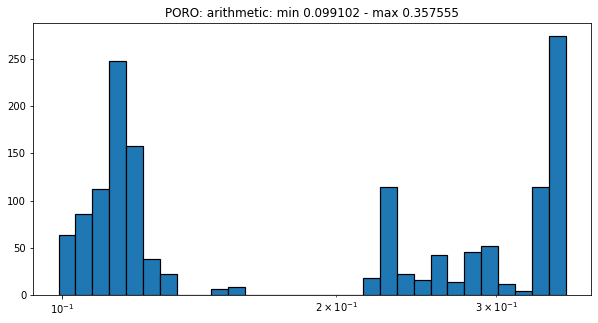

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 11760
     NumOfCells 1470
     .....Done!
[Output] Writing "Results/PILLAR_Grid_Coarse.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [3]:
# 3.1 Set coarsening factor (grid dimensions of coarse cells)
Model.GRDECL_Data.coarse2fine_ratio=[2]*3

# 3.2 Create coarse grid and upscale porosity
Model2=Model.create_coarse_model()

Model2.plot_scalar("PORO",ITK=True).show()